In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit
from tied_utils import simulated_tied_ddm_norm, tied_data_gen_wrapper, rho_E_minus_small_t_NORM_TIED_fn
from scipy.integrate import quad

# Params

In [2]:
# Stim params
ILD = 6
ABL_1 = 20
ABL_2 = 40
ABL_3 = 60
ABL_arr = [ABL_1, ABL_2, ABL_3]

# Model params
rate_lambda = 0.076
theta_E = 50.7
T_0 = 0.19*(1e-3)
t_non_decision = 78e-3

# sim params
N_sim = int(1e6)
dt = 1e-4

# fitting params
K_max = 10

# Gen data

In [3]:
sim_results = Parallel(n_jobs=-1)(delayed(tied_data_gen_wrapper)(ILD, ABL_arr, rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))
choice_arr = np.array([x['choice'] for x in sim_results])
RT_arr = np.array([x['rt'] for x in sim_results])

ABL_arr = np.array([x['ABL'] for x in sim_results])
ILD_arr = np.array([x['ILD'] for x in sim_results])

ABLs_unique = np.unique(ABL_arr)

choices_by_ABL = {}; RTs_by_ABL = {}
for ABL in ABLs_unique:
    choices_by_ABL[ABL] = choice_arr[ABL_arr == ABL]
    RTs_by_ABL[ABL] = RT_arr[ABL_arr == ABL]

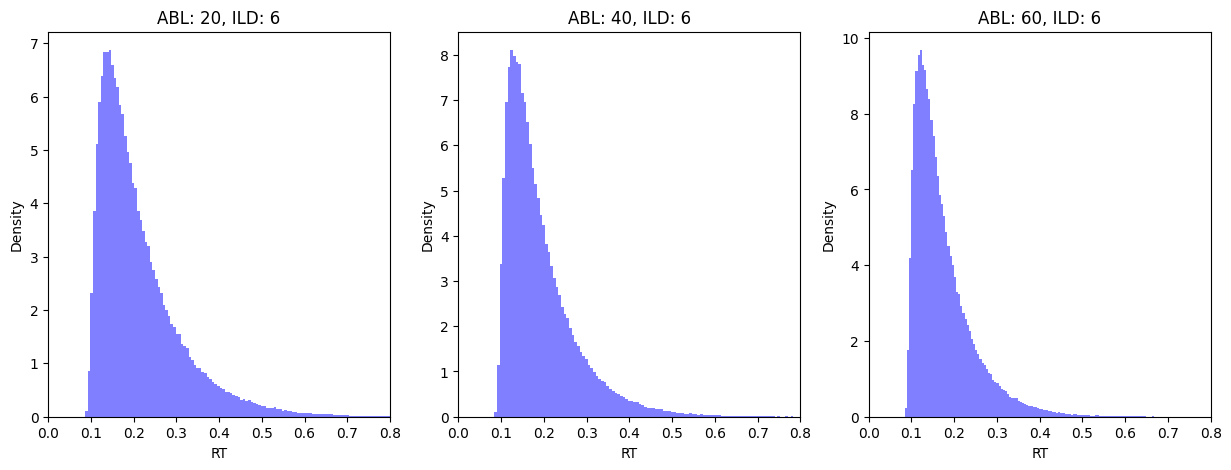

In [5]:
plt.figure(figsize=(15,5))
for i in range(1,len(ABLs_unique)+1):
    plt.subplot(1, len(ABLs_unique), i)
    plt.hist(RTs_by_ABL[ABLs_unique[i-1]], bins=200, color='b', alpha=0.5, density=True)
    plt.title(f'ABL: {ABLs_unique[i-1]}, ILD: {ILD}')
    plt.xlabel('RT'); plt.ylabel('Density');
    plt.xlim([0, 0.8])

# Fit correct and wrong RT in each ABL

# theory curves normalized

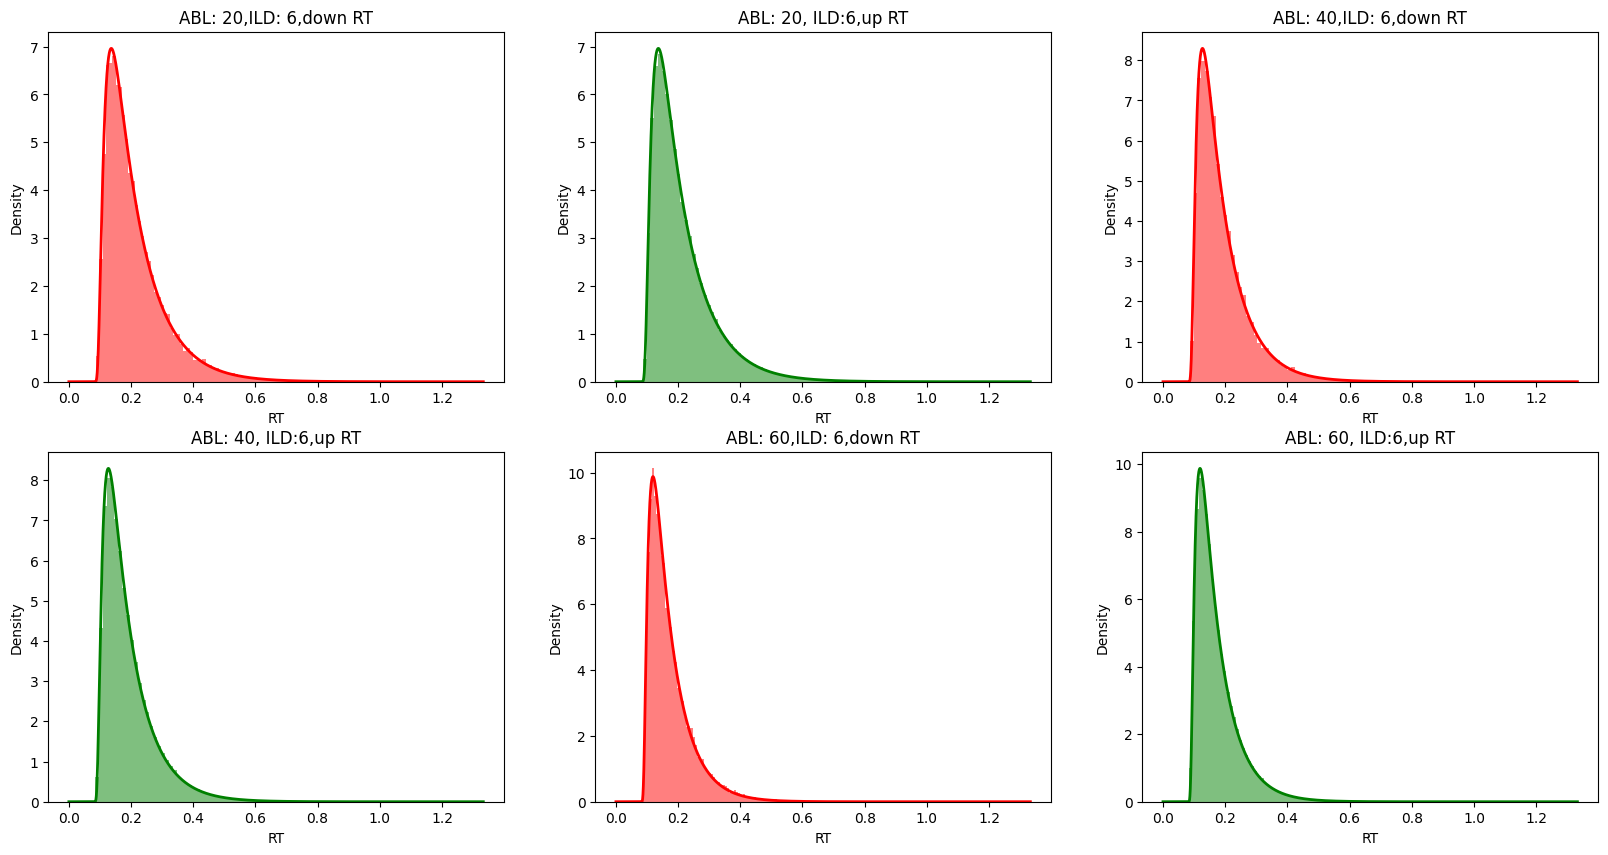

In [6]:
t_pts = np.linspace(0.0001, max(RT_arr), 10000)

plt.figure(figsize=(20,10))
fig_num = 1
for i in range(len(ABLs_unique)):
    ABL_i = ABLs_unique[i]
    choices_ABL_i = choices_by_ABL[ABL_i]
    RTs_ABL_i = RTs_by_ABL[ABL_i]

    choices_down_ABL_i_idx = np.where(choices_ABL_i == -1)[0]
    RTs_down_ABL_i = RTs_ABL_i[choices_down_ABL_i_idx]

    choices_up_ABL_i_idx = np.where(choices_ABL_i == 1)[0]
    RTs_up_ABL_i = RTs_ABL_i[choices_up_ABL_i_idx]
    PDF_RT_ABL_i_down = [rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL_i, rate_lambda, theta_E, T_0, t_non_decision, K_max) for t in t_pts]
    integral_norm_term = np.array(quad(rho_E_minus_small_t_NORM_TIED_fn, 0, np.inf, args=(ILD, ABL_i, rate_lambda, theta_E, T_0, t_non_decision, K_max))[0])

    PDF_RT_ABL_i_down_norm = PDF_RT_ABL_i_down/integral_norm_term

    PDF_RT_ABL_i_up = [rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL_i, rate_lambda, -theta_E, T_0, t_non_decision, K_max) for t in t_pts]
    integral_norm_term = np.array(quad(rho_E_minus_small_t_NORM_TIED_fn, 0, np.inf, args=(ILD, ABL_i, rate_lambda, -theta_E, T_0, t_non_decision, K_max))[0])
    PDF_RT_ABL_i_up_norm = PDF_RT_ABL_i_up/integral_norm_term

    plt.subplot(2,3,fig_num)
    plt.hist(RTs_down_ABL_i, bins=100, color='r', alpha=0.5, density=True);
    plt.plot(t_pts, PDF_RT_ABL_i_down_norm, color='r', linewidth=2);
    plt.title(f'ABL: {ABL_i},ILD: {ILD},down RT'); plt.xlabel('RT'); plt.ylabel('Density');
    fig_num += 1

    plt.subplot(2,3,fig_num)
    plt.hist(RTs_up_ABL_i, bins=100, color='g', alpha=0.5, density=True);
    plt.plot(t_pts, PDF_RT_ABL_i_up_norm, color='g', linewidth=2);
    plt.title(f'ABL: {ABL_i}, ILD:{ILD},up RT'); plt.xlabel('RT'); plt.ylabel('Density');
    fig_num += 1


# theory curves non-norm

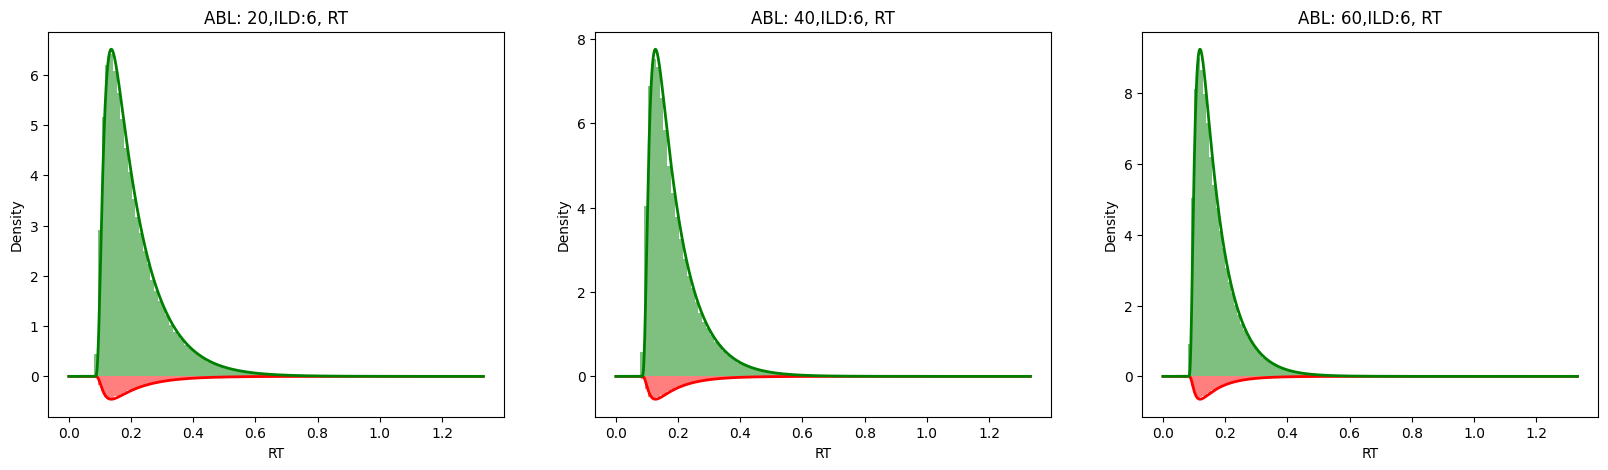

In [7]:
t_pts = np.linspace(0.0001, max(RT_arr), 10000)

plt.figure(figsize=(20, 5))
fig_num = 1
for i in range(len(ABLs_unique)):
    ABL_i = ABLs_unique[i]
    choices_ABL_i = choices_by_ABL[ABL_i]
    RTs_ABL_i = RTs_by_ABL[ABL_i]

    choices_down_ABL_i_idx = np.where(choices_ABL_i == -1)[0]
    RTs_down_ABL_i = RTs_ABL_i[choices_down_ABL_i_idx]

    choices_up_ABL_i_idx = np.where(choices_ABL_i == 1)[0]
    RTs_up_ABL_i = RTs_ABL_i[choices_up_ABL_i_idx]

    PDF_RT_ABL_i_down = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL_i, rate_lambda, theta_E, T_0, t_non_decision, K_max) for t in t_pts])
    PDF_RT_ABL_i_up = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL_i, rate_lambda, -theta_E, T_0, t_non_decision, K_max) for t in t_pts])

    plt.subplot(1,3,fig_num)
    hist_down, bins_down = np.histogram(RTs_down_ABL_i, bins=100, density=True)
    hist_down *= len(choices_down_ABL_i_idx)/len(choices_ABL_i)

    plt.bar(bins_down[:-1], -hist_down, width=bins_down[1]-bins_down[0], color='r', alpha=0.5);
    plt.plot(t_pts, -PDF_RT_ABL_i_down, color='r', linewidth=2);

    hist_up, bins_up = np.histogram(RTs_up_ABL_i, bins=100, density=True)
    hist_up *= len(choices_up_ABL_i_idx)/len(choices_ABL_i)

    plt.bar(bins_up[:-1], hist_up, width=bins_up[1]-bins_up[0], color='g', alpha=0.5);
    plt.plot(t_pts, PDF_RT_ABL_i_up, color='g', linewidth=2);
    plt.title(f'ABL: {ABL_i},ILD:{ILD}, RT'); plt.xlabel('RT'); plt.ylabel('Density');

    fig_num += 1


# Verifying that TIED simulation - Norm and Non-norm are same

## Norm units sim

In [66]:
@jit
def simulated_tied_ddm_norm(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
    DV = 0; tau = 0; 

    chi = 17.37
    t_theta = T_0 * (theta_E**2) * (10**(-rate_lambda*ABL/20)) * (1/(2*np.cosh(rate_lambda*ILD/chi)))
    d_tau = dt/t_theta
    dB_tau = d_tau**0.5

    drift = theta_E * np.tanh(rate_lambda * ILD / chi)
    
    # print(f"Drift = {drift}, t_theta = {t_theta}, d_tau = {d_tau}, dB_tau = {dB_tau}")
    while True:
        DV += drift*d_tau + np.random.normal(0, dB_tau)
        tau += 1

        # bounds are +1 and -1 as simulation is done in normalized units
        if DV >= 1:
            return 1, (tau*d_tau)*t_theta + t_non_decision
        elif DV <= -1:
            return -1, (tau*d_tau)*t_theta + t_non_decision

In [67]:
results = Parallel(n_jobs=-1)(delayed(simulated_tied_ddm_norm)(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

In [68]:
choice_arr = np.array([res[0] for res in results])
RT_arr = np.array([res[1] for res in results])

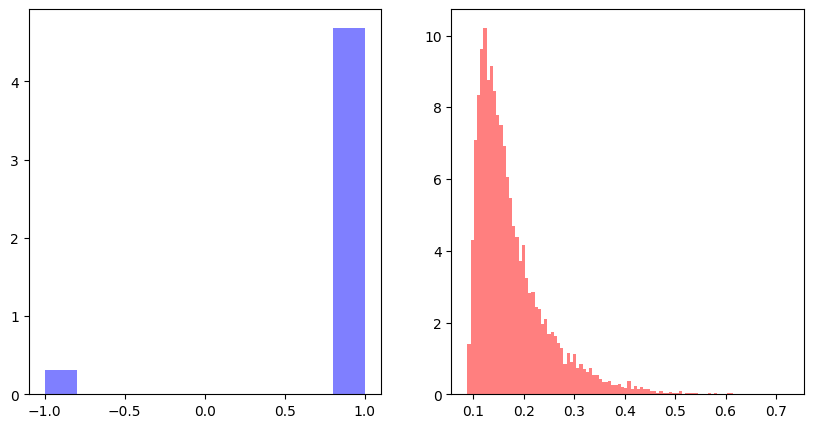

In [69]:
# plot histograms of choice and RT_arr side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(choice_arr, color='blue', alpha=0.5, density=True)

plt.subplot(1, 2, 2)
plt.hist(RT_arr, color='red', alpha=0.5, bins=100, density=True);

## Non-norm units sim

In [70]:
@jit
def simulate_tied_no_norm(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
    DV = 0; t = 0

    chi = 17.37; q_e = 1
    theta = theta_E * q_e
    mu = (2*q_e/T_0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    sigma = np.sqrt( (2*(q_e**2)/T_0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )
    dB = dt**0.5

    while True:
        DV += mu*dt + sigma*np.random.normal(0, dB)
        t += 1

        if DV >= theta:
            return 1, t*dt + t_non_decision
        elif DV <= -theta:
            return -1, t*dt + t_non_decision


In [71]:
results_2 = Parallel(n_jobs=-1)(delayed(simulate_tied_no_norm)(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

In [72]:
choice_arr_2 = np.array([res[0] for res in results_2])
RT_arr_2 = np.array([res[1] for res in results_2])

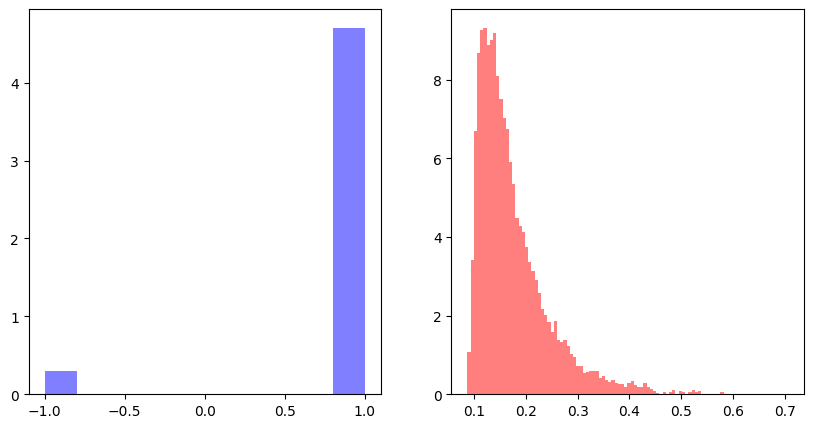

In [73]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(choice_arr_2, color='blue', alpha=0.5, density=True)

plt.subplot(1, 2, 2)
plt.hist(RT_arr_2, color='red', alpha=0.5, bins=100, density=True);

## Both same

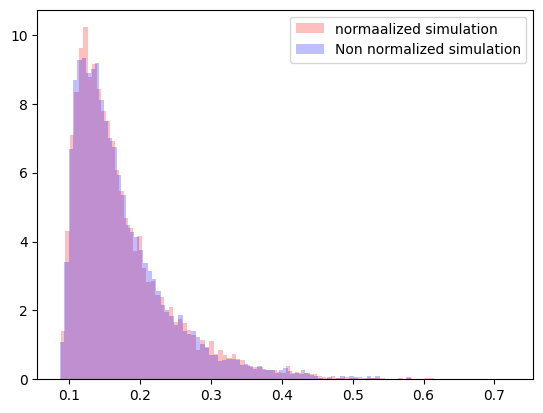

In [74]:
# compare RT_arr and RT_arr_2 histogram
plt.hist(RT_arr, color='red', alpha=0.25, bins=100, density=True, label='normaalized simulation');
plt.hist(RT_arr_2, color='blue', alpha=0.25, bins=100, density=True, label='Non normalized simulation');
plt.legend();